In [1]:
%run Data_Helpers.ipynb
%run Keras_Helpers.ipynb

import tensorflow as tf
import pandas as pd
import re

In [2]:
# Thanks, https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset
def get_title(name):
    title_search = re.search(r'\b([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ''

def prepare_data(df):
    df = df.filter(items=[
        'name',
        'sex',
        'age',
        'sibsp',
        'parch',
        'ticket',
        'fare',
        'pclass',
        'cabin',
        'embarked',
        'home.dest',
        'survived'
    ])
    extract_unknown(df, 'age')
    extract_unknown(df, 'fare')
    split_categories(df, 'sex', ['male', 'female'])
    split_categories(df, 'pclass', ['1', '2', '3'])
    split_categories(df, 'embarked', ['S', 'C', 'Q'])
    df['family_size'] = df['sibsp'] + df['parch'] + 1
    df['alone'] = df['family_size'] == 1
    df['title'] = df['name'].apply(get_title)
    df['title_Rare'] = df['title'].isin([
        'Lady', 'Countess', 'Dona',
        'Sir', 'Don',
        'Col', 'Capt', 'Rev', 'Dr', 'Major', 'Jonkheer',
    ]).astype(int)
    split_categories(df, 'title', [
        'Mrs', 'Ms', 'Miss', 'Mme', 'Mlle', 'Dona', 'Lady', 'Countess',
        'Mr', 'Master',                     'Sir', 'Don',
        'Col', 'Capt', 'Rev', 'Dr', 'Major', 'Jonkheer',
    ])
    return df

In [3]:
raw_data = pd.read_csv('data/titanic.csv')
[raw_train_data, raw_test_data, raw_validate_data] = divide_data(raw_data, [0.8, 0.1, 0.1])

In [4]:
train_data = prepare_data(raw_train_data)
test_data = prepare_data(raw_test_data)
validate_data = prepare_data(raw_validate_data)

In [5]:
display_wide(train_data.head())

,name,sex_male,sex_female,age_known,age,sibsp,parch,ticket,fare_known,fare,pclass_1,pclass_2,pclass_3,cabin,embarked_S,embarked_C,embarked_Q,home.dest,survived,family_size,alone,title_Mrs,title_Ms,title_Miss,title_Mme,title_Mlle,title_Dona,title_Lady,title_Countess,title_Mr,title_Master,title_Sir,title_Don,title_Col,title_Capt,title_Rev,title_Dr,title_Major,title_Jonkheer,title_Rare
137,"Graham, Miss. Margaret Edith",0,1,1,19.0,0,0,112053,1,30.0000,1,0,0,B42,1,0,0,"Greenwich, CT",1,1,True,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
790,"Elias, Mr. Joseph",1,0,1,39.0,0,2,2675,1,7.2292,0,0,1,NaN,0,1,0,"Syria Ottawa, ON",0,3,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
892,"Johansson, Mr. Karl Johan",1,0,1,31.0,0,0,347063,1,7.7750,0,0,1,NaN,1,0,0,NaN,0,1,True,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
133,"Goldenberg, Mr. Samuel L",1,0,1,49.0,1,0,17453,1,89.1042,1,0,0,C92,0,1,0,"Paris, France / New York, NY",1,2,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
702,"Canavan, Miss. Mary",0,1,1,21.0,0,0,364846,1,7.7500,0,0,1,NaN,0,0,1,NaN,0,1,True,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
def make_model_output(df):
    return df.filter(items=['survived'])

def make_model(df_in, df_out):
    # https://keras.io/models/sequential/
    model = tf.keras.Sequential([
        # https://keras.io/layers/core/
        tf.keras.layers.Dense(units=16, activation='relu', input_dim=df_in.shape[1]),
        tf.keras.layers.Dense(units=16, activation='relu'),
        tf.keras.layers.Dense(units=df_out.shape[1], activation='sigmoid')
    ])
    model.compile(
        loss      = tf.keras.losses.binary_crossentropy, # https://keras.io/losses/
        optimizer = tf.keras.optimizers.Nadam(), # https://keras.io/optimizers/
        metrics   = ['accuracy']
    )
    return model

Fitting none...
  train: loss = 0.65926445  accuracy = 0.6294    test: loss = 0.66918685  accuracy = 0.6107


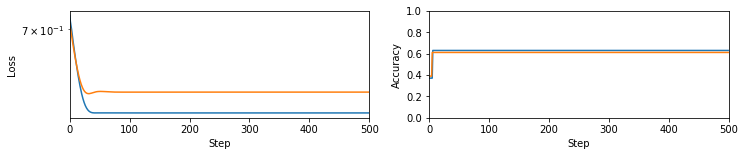

Training complete


In [7]:
resultsNone = train_neural_networks(make_model, train_data, test_data, [
    InputFn('none', lambda df: df.filter(items=[]).assign(One=1)),
], make_model_output, max_epochs = 500)

Fitting sex...
  train: loss = 0.52678925  accuracy = 0.7765    test: loss = 0.49479942  accuracy = 0.8015


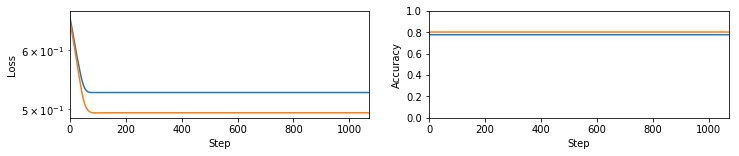

Fitting age known...
  train: loss = 0.65360421  accuracy = 0.6294    test: loss = 0.66890919  accuracy = 0.6107


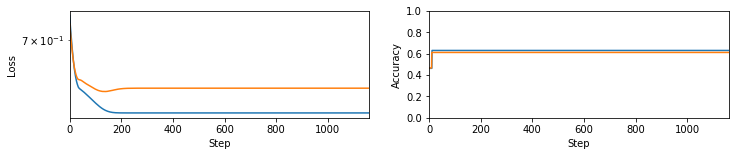

Fitting age...
  train: loss = 0.63704866  accuracy = 0.6523    test: loss = 0.7182547  accuracy = 0.5954


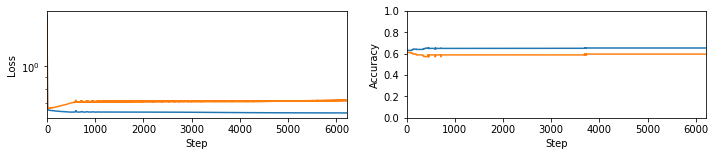

Training complete


In [8]:
models1 = train_neural_networks(make_model, train_data, test_data, [
    InputFn('sex', lambda df: df.filter(items=[
        'sex_male',
        'sex_female',
    ])),
    InputFn('age known', lambda df: df.filter(items=[
        'age_known',
    ])),
    InputFn('age', lambda df: df.filter(items=[
        'age_known',
        'age',
    ])),
], make_model_output)

Fitting sex / embarked...
  train: loss = 0.51342809  accuracy = 0.7765    test: loss = 0.4580018  accuracy = 0.8015


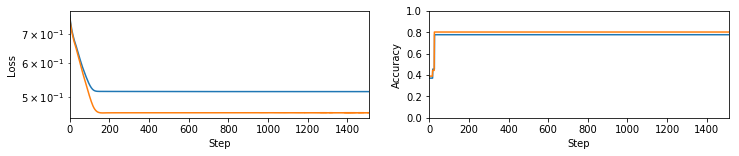

Fitting sex / class...
  train: loss = 0.46444055  accuracy = 0.7861    test: loss = 0.48856214  accuracy = 0.7481


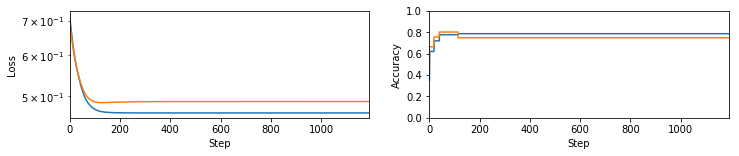

Fitting sex / family...
  train: loss = 0.48751706  accuracy = 0.7908    test: loss = 0.46337983  accuracy = 0.8321


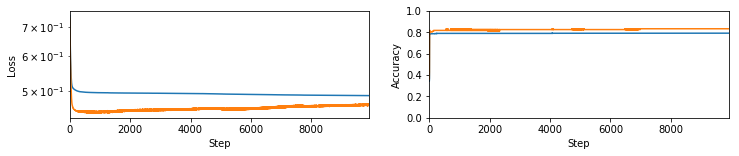

Fitting sex / embarked / class...
  train: loss = 0.45630595  accuracy = 0.7994    test: loss = 0.47963564  accuracy = 0.7786


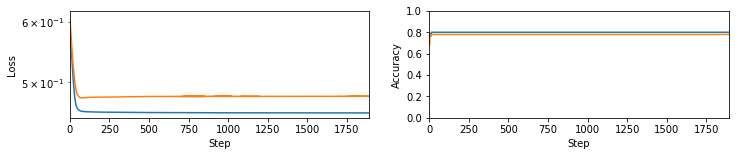

Fitting sex / embarked / class / family...
  train: loss = 0.39042285  accuracy = 0.8223    test: loss = 0.68886773  accuracy = 0.7252


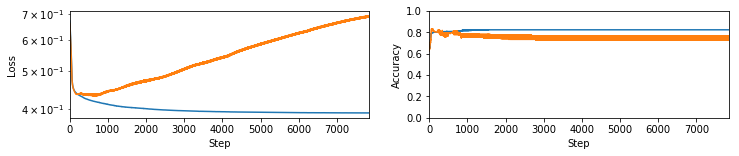

Fitting sex / age...
  train: loss = 0.48776174  accuracy = 0.7956    test: loss = 0.69675118  accuracy = 0.7939


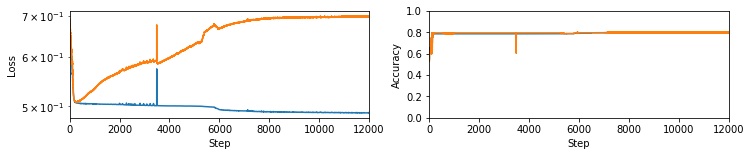

Fitting sex / age / fare...
  train: loss = 0.42176324  accuracy = 0.808    test: loss = 0.59276152  accuracy = 0.7786


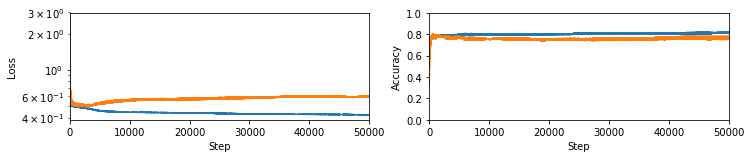

Fitting sex / age / embarked...
  train: loss = 0.48084912  accuracy = 0.7889    test: loss = 0.51393181  accuracy = 0.8168


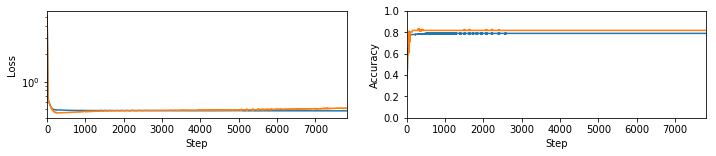

Fitting sex / age / embarked / fare...
  train: loss = 0.38908142  accuracy = 0.8348    test: loss = 0.75216547  accuracy = 0.7328


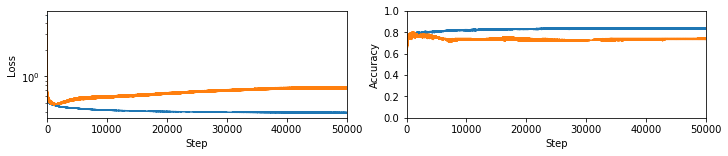

Fitting sex / age / class...
  train: loss = 0.39732784  accuracy = 0.8223    test: loss = 0.79784335  accuracy = 0.7328


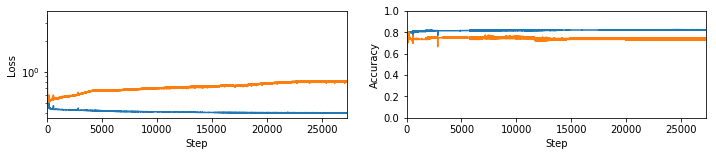

Fitting sex / age / family...
  train: loss = 0.43731394  accuracy = 0.8185    test: loss = 0.95560177  accuracy = 0.8244


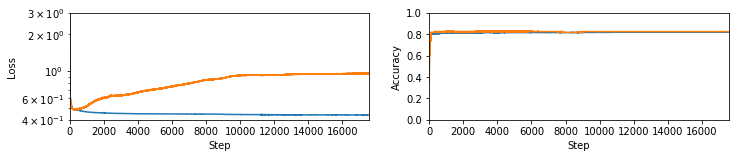

Fitting sex / age / family / class...
  train: loss = 0.36481893  accuracy = 0.8405    test: loss = 0.84083647  accuracy = 0.771


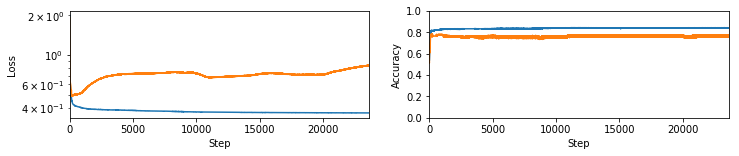

Fitting sex / age / family / class / embarked / fare...
  train: loss = 0.22639416  accuracy = 0.9064    test: loss = 1.731664  accuracy = 0.7176


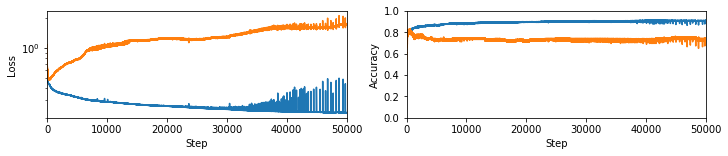

Training complete


In [9]:
models2 = train_neural_networks(make_model, train_data, test_data, [
    InputFn('sex / embarked', lambda df: df.filter(items=[
        'sex_male',
        'sex_female',
        'embarked_S',
        'embarked_C',
        'embarked_Q',
    ])),
    InputFn('sex / class', lambda df: df.filter(items=[
        'sex_male',
        'sex_female',
        'pclass_1',
        'pclass_2',
        'pclass_3',
    ])),
    InputFn('sex / family', lambda df: df.filter(items=[
        'sex_male',
        'sex_female',
        'sibsp',
        'parch',
    ])),
    InputFn('sex / embarked / class', lambda df: df.filter(items=[
        'sex_male',
        'sex_female',
        'embarked_S',
        'embarked_C',
        'embarked_Q',
        'pclass_1',
        'pclass_2',
        'pclass_3',
    ])),
    InputFn('sex / embarked / class / family', lambda df: df.filter(items=[
        'sex_male',
        'sex_female',
        'embarked_S',
        'embarked_C',
        'embarked_Q',
        'pclass_1',
        'pclass_2',
        'pclass_3',
        'sibsp',
        'parch',
    ])),
    InputFn('sex / age', lambda df: df.filter(items=[
        'sex_male',
        'sex_female',
        'age_known',
        'age',
    ])),
    InputFn('sex / age / fare', lambda df: df.filter(items=[
        'sex_male',
        'sex_female',
        'age_known',
        'age',
        'fare_known',
        'fare',
    ])),
    InputFn('sex / age / embarked', lambda df: df.filter(items=[
        'sex_male',
        'sex_female',
        'age_known',
        'age',
        'embarked_S',
        'embarked_C',
        'embarked_Q',
    ])),
    InputFn('sex / age / embarked / fare', lambda df: df.filter(items=[
        'sex_male',
        'sex_female',
        'age_known',
        'age',
        'embarked_S',
        'embarked_C',
        'embarked_Q',
        'fare_known',
        'fare',
    ])),
    InputFn('sex / age / class', lambda df: df.filter(items=[
        'sex_male',
        'sex_female',
        'age_known',
        'age',
        'pclass_1',
        'pclass_2',
        'pclass_3',
    ])),
    InputFn('sex / age / family', lambda df: df.filter(items=[
        'sex_male',
        'sex_female',
        'age_known',
        'age',
        'sibsp',
        'parch',
    ])),
    InputFn('sex / age / family / class', lambda df: df.filter(items=[
        'sex_male',
        'sex_female',
        'age_known',
        'age',
        'sibsp',
        'parch',
        'pclass_1',
        'pclass_2',
        'pclass_3',
    ])),
    InputFn('sex / age / family / class / embarked / fare', lambda df: df.filter(items=[
        'sex_male',
        'sex_female',
        'age_known',
        'age',
        'sibsp',
        'parch',
        'pclass_1',
        'pclass_2',
        'pclass_3',
        'embarked_S',
        'embarked_C',
        'embarked_Q',
        'fare_known',
        'fare',
    ])),
], make_model_output)